# 오피지지 분석과제 - Data Scientist

### - 작성자 : 김재민
### - 지원 회사 : 오피지지
### - 지원 분야 : 데이터 사이언스
### - 과제 설명 :
    - 오피지지에서 제공한 "롤" 경기의 위치 데이터를 1~3차 분석 과정을 통해 여러 방향으로 분류 분석하였습니다. 

### 문제 1번
- (1) 레드 팀 정글러 챔피언 '리신'에 대해서 1분 30초부터 3분 30초까지의 초반 정글 동선을 분석하고자 합니다.
몇 가지 동선으로 분류할 수 있을까요? 제공된 챔피언 위치 데이터를 사용하여, '리신'의 초반 정글 동선이 유사
한 경기들을 분류해 주세요.
분석이 어려운 영상의 경우에는 분석에 직접적으로 활용하지 않으셔도 되지만, 활용하기에 어려웠던 이유를 같
이 남겨주시기 바랍니다.

### 1. 라이브러리

In [102]:
import os
import pandas as pd
import numpy as np
from glob import glob
import yaml
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

### 2. 메타데이터
- 제공된 메타 데이터를 csv 파일로 저장하여 데이터프레임 생성

In [80]:
# 메타데이터 -> 데이터프레임 로드
df_meta = pd.read_csv("./datas/opgg_lol_metadata.csv")
df_meta.tail(3)

,Name,MatchID,VideoUrl,StartTime,EnemyJungler,Winner,Patch
16,VYnijgikia4,5353629623,https://www.youtube.com/watch?v=VYnijgikia4,0:02,Sejuani,Red,11.15
17,OZpVbV-CK2s,5369856875,https://www.youtube.com/watch?v=OZpVbV-CK2s,1:01,Viego,Blue,11.15
18,3CW1nm5C1w,5368955793,https://www.youtube.com/watch?v=-3CW1nm5C1w,1:04,Nidalee,Red,11.15


In [81]:
# 메타데이터의 Name 종류 확인(중복제거)
names = list(set(df_meta["Name"]))
print('- 메타데이터의 Name 개수 : {0}'.format(len(names)))
print('- 메타데이터의 Name 값 : ', names, sep='\n')

- 메타데이터의 Name 개수 : 19
- 메타데이터의 Name 값 : 
['sNW-KwhVqZs', 'KbTmkrALaLM', '0I-1-U7bcgY', 'OZpVbV-CK2s', 'oRMVvIriewU', 'dAGL5xrydUo', 'VYnijgikia4', 'bidqBtK0Hd8', 'uu03GFrI1wU', '3EzTJ4tmXKA', 'ZhoROlQluXw', 'Sodn83u_kFQ', 'uk4g0gt-NQE', 'm_jhvqtmoE', '3CW1nm5C1w', 'SV5_cPym_7o', 'wDE_YLycT4M', 'jOUK8efu2EM', 'NPL3AENowDo']


### 3. 챔피언 위치 데이터
- 메타데이터의 각 Name 값을 하나의 영상 이름으로 지정
- 모든 영상의 시간별 위치 데이터를 하나의 데이터프레임으로 로드

In [4]:
# 데이터 경로
path = ".\\datas\\opgg_data_project"

# 데이터 경로, 파일 경로 리스트
path_labeles = [ os.path.join(path, name, "labels", "*") for name in names ]
files = [b for a in path_labeles for b in glob(a) ]

# 파일 재생성 -> 구분자 " "
# 전체 위치 데이터를 result.txt 파일에
with open(".\\datas\\result.txt", "w") as out_file:
    for file in files:
        name = file.split("\\")[3]
        file_id = file.split("_")[-1].replace(".txt", "")
        with open(file, "r") as f:
            for line in f.readlines():
                input_line = line.replace("\n", " {0} {1}\n ".format(name, file_id))
                out_file.write(input_line)

In [5]:
# 컬럼을 colums 와 같이 지정하여 위치데이터 파일을 데이터프레임으로 로드
columns = ["ClassID", "X", "Y", "Width", "Height", "Confidence", "Name", "Seconds"]
df_loc = pd.read_csv(".\\datas\\result.txt", sep = " ", names=columns, header=0, encoding = "utf-8" ).reset_index(drop=True)[:-1]

In [6]:
df_loc.tail(3)

,ClassID,X,Y,Width,Height,Confidence,Name,Seconds
165284,110.0,0.122302,0.631295,0.086331,0.089928,0.901457,NPL3AENowDo,999.0
165285,72.0,0.508993,0.543165,0.089928,0.093525,0.911668,NPL3AENowDo,999.0
165286,34.0,0.629496,0.615108,0.093525,0.093525,0.913330,NPL3AENowDo,999.0


### 3-1. Normalization 된 X, Y, Width, Height 값의 원본 좌표 값으로 변경

In [7]:
# 과학적 표기법 제거
pd.set_option('display.float_format', None)
df_loc[["X", "Y", "Width", "Height"]] =  df_loc[["X", "Y", "Width", "Height"]].apply(lambda x : x*288)
df_loc.tail(3)

,ClassID,X,Y,Width,Height,Confidence,Name,Seconds
165284,110.0,35.222976,181.812960,24.863299,25.899293,0.901457,NPL3AENowDo,999.0
165285,72.0,146.589984,156.431520,25.899293,26.935258,0.911668,NPL3AENowDo,999.0
165286,34.0,181.294848,177.151104,26.935258,26.935258,0.913330,NPL3AENowDo,999.0


### 3-2. 메타데이터와 위치데이터 합치기
- 위치 데이터의 Name 값과 메타데이터의 Name 값을 Join key로 Merge

In [8]:
# 메타데이터 데이터프레임에서 특정 컬럼 지정
df_meta = df_meta[["Name","MatchID", "StartTime", "EnemyJungler", "Winner"]]
df_loc_meta = df_loc.merge(df_meta, left_on="Name", right_on="Name", how="left")
df_loc_meta.tail(3)

,ClassID,X,Y,Width,Height,Confidence,Name,Seconds,MatchID,StartTime,EnemyJungler,Winner
165284,110.0,35.222976,181.812960,24.863299,25.899293,0.901457,NPL3AENowDo,999.0,5353719037,1:15,Viego,Red
165285,72.0,146.589984,156.431520,25.899293,26.935258,0.911668,NPL3AENowDo,999.0,5353719037,1:15,Viego,Red
165286,34.0,181.294848,177.151104,26.935258,26.935258,0.913330,NPL3AENowDo,999.0,5353719037,1:15,Viego,Red


### 3-3. StartTime 값 데이터 타입 변환
- 녹화 시작시간을 "초"단위로 구하기
- 녹화가 진행된 시간(초)을 의미하는 "Seconds" 컬럼과 StartTime 값을 더하여 현재 시간 구하기
- 1분 30초부터 ~ 3분 30초까지의 데이터 추출

In [9]:
# StartTime 타입 변환
df_loc_meta["StartTimeAsDate"] = pd.to_datetime(df_loc_meta["StartTime"], format="%M:%S") - pd.to_datetime("1900-01-01 00:00:00", format="%Y-%m-%d %H:%M:%S")
df_loc_meta["StartTimeSeconds"] = df_loc_meta[["StartTimeAsDate"]]/ np.timedelta64(1, 's')
df_loc_meta["NowTimeSeconds"] = df_loc_meta["StartTimeSeconds"] + df_loc_meta["Seconds"]
df_loc_meta.drop(["StartTimeAsDate"], axis=1, inplace=True)
# 1분 30초 이상 3분 30초 이하 데이터 필터
df_loc_meta = df_loc_meta.loc[(df_loc_meta["NowTimeSeconds"]<=210) & (df_loc_meta["NowTimeSeconds"]>=90)].reset_index(drop=True)
df_loc_meta.tail(3)

,ClassID,X,Y,Width,Height,Confidence,Name,Seconds,MatchID,StartTime,EnemyJungler,Winner,StartTimeSeconds,NowTimeSeconds
14703,141.0,140.37408,190.618560,25.899293,26.935258,0.904262,NPL3AENowDo,99.0,5353719037,1:15,Viego,Red,75.0,174.0
14704,72.0,235.68336,246.043296,25.899293,25.899293,0.911041,NPL3AENowDo,99.0,5353719037,1:15,Viego,Red,75.0,174.0
14705,34.0,53.87040,48.172608,26.935258,25.899293,0.913282,NPL3AENowDo,99.0,5353719037,1:15,Viego,Red,75.0,174.0


### 4. 챔피언 클래스 아이디(리신, 67번)
- PyYAML 라이브러리를 이용하여 챔피언 클래스 아이디 yaml 파일 로드
- 순서 0번 클래스 아이디부터 챔피언 아이디와 1대1 매칭
- PyYAML 라이브러리 설치 :  pip install PyYAML

In [10]:
# PyYAML 라이브러리를 이용하여 챔피언 클래스 아이디 yaml 파일 로드
champ_class_ls = []
with open(".\\datas\\champion_class_id.yaml") as file:
    conf = yaml.load(file, Loader=yaml.FullLoader)
    for id, name in enumerate(conf["names"]):
        champ_class_ls.append({"ClassID":id, "ChampionName":name})

In [103]:
# 챔피언 클래스 아이디 정보 데이터프레임 생성
df_champ = pd.DataFrame(champ_class_ls)
df_champ.loc[df_champ["ChampionName"] == "LeeSin"].tail(3)

,ClassID,ChampionName
67,67,LeeSin


### 4-1. 위치 데이터와 챔피언 클래스 아이디 Merge
- 위치 데이터의 "ClassID"와 챔피언 클래스 아이디 "ClassID"를 Key 값으로 Join하여 각 행의 플레이어 챔피언 이름 매칭

In [12]:
df_res = df_loc_meta.merge(df_champ, left_on="ClassID", right_on="ClassID", how="inner")
df_res.tail(3)

,ClassID,X,Y,Width,Height,Confidence,Name,Seconds,MatchID,StartTime,EnemyJungler,Winner,StartTimeSeconds,NowTimeSeconds,ChampionName
14703,137.0,210.820032,245.007072,21.755405,25.899293,0.510271,NPL3AENowDo,124.0,5353719037,1:15,Viego,Red,75.0,199.0,Vayne
14704,36.0,54.906336,36.258912,26.935258,22.791370,0.614475,NPL3AENowDo,27.0,5353719037,1:15,Viego,Red,75.0,102.0,Gragas
14705,109.0,172.489248,203.050368,25.899293,26.935258,0.845611,NPL3AENowDo,82.0,5353719037,1:15,Viego,Red,75.0,157.0,Seraphine


### 4-2. "LeeSin" 챔피언의 데이터 추출

In [13]:
# 챔피언 이름이 "LeeSin"인 것만 추출
df_res = df_res.loc[ (df_res["ChampionName"] == "LeeSin") ].reset_index(drop=True)
df_res.tail(3)

,ClassID,X,Y,Width,Height,Confidence,Name,Seconds,MatchID,StartTime,EnemyJungler,Winner,StartTimeSeconds,NowTimeSeconds,ChampionName
1946,67.0,161.093664,95.309280,25.899293,26.935258,0.843117,NPL3AENowDo,97.0,5353719037,1:15,Viego,Red,75.0,172.0,LeeSin
1947,67.0,165.755520,98.417376,26.935258,26.935258,0.859109,NPL3AENowDo,98.0,5353719037,1:15,Viego,Red,75.0,173.0,LeeSin
1948,67.0,170.417376,102.561120,25.899293,26.935258,0.856168,NPL3AENowDo,99.0,5353719037,1:15,Viego,Red,75.0,174.0,LeeSin


### [ 위치별 데이터 산점도 시각화를 통한 분리 분석 ]
- 목표 : 
    - 그려지는 산점도를 보고 눈에 띄는 이동 패던 파악과, 가장 밀집 되어 있는 이동 경로를 확인해본다.

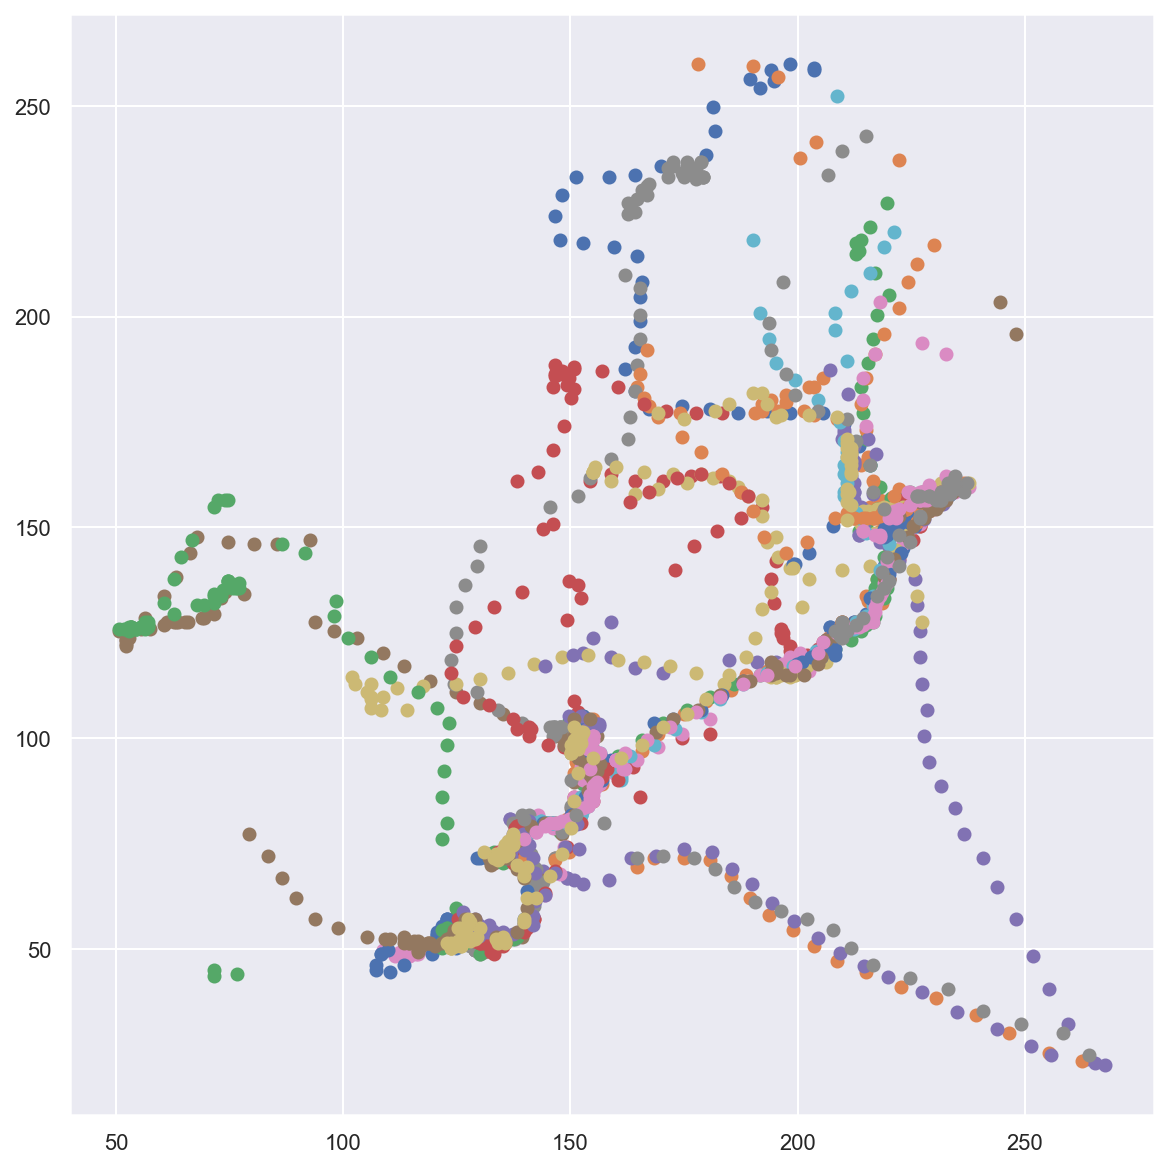

In [14]:
# 차트 영역 크기 설정
plt.figure(figsize=(8,8), constrained_layout=True)

for name in names:
    data = df_res[["Name", "NowTimeSeconds", "X", "Y"]].loc[df_res["Name"] == name].reset_index(drop=True)
    x = data["X"]
    y = data["Y"]
    plt.scatter(x, y)
plt.show()

### 🚩1차 분석 결과
- 산점도를 보았을 때 레드 진영에서 시작하는 정글 포지션의 리신은 블루, 레드 몬스터가 발현 되는 바텀(봇) 방향의 정글 라인을 이동하는 플레이를 제일 많이 하는 것으로 관찰 된다.
- 또한, 정글 라인을 지나 바텀(봇)에 있는 챔피언을 지원하기 위한 움직임도 같이 관찰 되고 있다.
- 게임 용어 역버프, 정버프를 할 때의 움직임도 관찰 되는 것으로 보이지만 좌표별 시간 흐름을 현재 산점도만을 보고는 파악이 어렵다.

---

### [ SVM 선형분리 모델을 이용한 분리 분석 ]
- 목표 : 결정 경계로 구분 되는 영역의 색상 개수를 확인하여 전체 녹화 영상 중 비슷한 움직임의 유형 개수를 구해본다.

In [20]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [21]:
# 2차원의 np.array 형태 X 생성
X = np.empty((0,2))
# 1차원의 np.array 형태 y 생성
y = np.empty((0,1))

In [22]:
# 녹화 영상 이름별 2차원 X와 1차원 y의 데이터 생성
for name_id, name in enumerate(names):
    _ = np.array(df_res.loc[df_res["Name"] == name][["X", "Y"]])
    X = np.append(X, _, axis=0)
    y = np.append(y, np.array([name_id] * len(_)))

In [23]:
# 2차원 X데이터의 x좌표와 y좌표 데이터를 각각 X0와 X1으로 선언하여 meshgrid() 함수를 이용해 그리드 생성
X0 = X[:,0]
X1 = X[:,1]
xx, yy = np.meshgrid(X0, X1)

In [24]:
# X, y 데이터 학습 SVM 모델 생성
model = svm.SVC(kernel='linear', C=100)
model.fit(X, y)

SVC(C=100, kernel='linear')

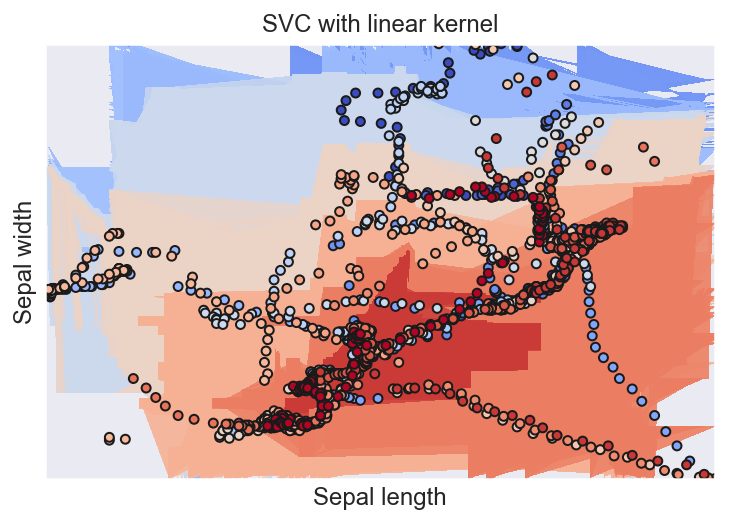

In [25]:
# 학습 모델을 이용한 SVC 선형 분리 그래프 출력
title = 'SVC with linear kernel'

fig, sub = plt.subplots(1, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax = sub
plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)

plt.show()

### 🚩2차 분석 결과
- SVM 선형 분리 모델을 이용하여 각 녹화 경기의 위치 데이터를 분류하면 결정 경계(Decision Boundary)가 총 6가지의 색상으로 분류 된다.
- 6개의 결정 경계 중 파란 계열 색상의 영역은 결경 경계를 구분하는 마진이 너무 좁은 영역이므로 하나의 분류로 취급 한다.
- 따라서, 레드팀에서 시작한 "리신" 챔피언의 이동 경로는 총 5가지로 분류 해볼 수 있다.

---

### [ SVM 선형 분리 학습을 통한 교차 검증 분석 ]
- 녹화 영상의 위치 데이터별 교차 검증을 통해 경로 이동이 비슷한 Name을 분류한다.
    - 각 경기별로 교차 검증을 통해 도출된 스코어 점수 비교 -> 스코어가 0.85 이상인 경우 같은 성격의 이동 동선으로 분류
    - X, Y, WIdth, Height 값을 독립 변수로 지정

In [90]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [92]:
print("안내 : 교차 검증 점수가 0.85 이상인 데이터 결과가 출력 됩니다.")
result_clf = {}
for name_id, name in enumerate(names):
    result_clf[name] = []
    X_1 = np.empty((0,4))
    y_1 = np.empty((0,1))
    _ = np.array(df_res.loc[df_res["Name"] == name][["X", "Y", "Width", "Height"]])
    X_1 = np.append(X_1, _, axis=0)
    y_1 = np.append(y_1, np.array([name_id] * len(_)))
    
    for name_id_2, name_2 in enumerate(names):
        row_data = {}
        if name_2 == name:
            continue
            
        X_2 = np.empty((0,4))
        y_2 = np.empty((0,1))
        __ = np.array(df_res.loc[df_res["Name"] == name_2][["X", "Y", "Width", "Height"]])
        X_2 = np.append(X_2, __, axis=0)
        y_2 = np.append(y_2, np.array([name_id_2] * len(__)))

        X_data = np.append(X_1, X_2, axis=0)
        y_data = np.append(y_1, y_2)

        svm_clf =svm.SVC(kernel = 'linear')
        scores = cross_val_score(svm_clf, X_data, y_data, cv = 5)
        
        # 교차 검증 평균이 0.85 점 이상일 때 비슷한 동선으로 분류
        if scores.mean() >= 0.85:
            row_data["Name"] = name_2
            row_data["Score"] = round(scores.mean(), 3)
            print('{}과 {}의 교차검증 평균: '.format(name, name_2), round(scores.mean(), 3))
            result_clf[name].append(row_data)
            

안내 : 교차 검증 점수가 0.85 이상인 데이터 결과가 출력 됩니다.
sNW-KwhVqZs과 dAGL5xrydUo의 교차검증 평균:  1.0
sNW-KwhVqZs과 uk4g0gt-NQE의 교차검증 평균:  1.0
sNW-KwhVqZs과 m_jhvqtmoE의 교차검증 평균:  0.881
sNW-KwhVqZs과 3CW1nm5C1w의 교차검증 평균:  0.897
KbTmkrALaLM과 uk4g0gt-NQE의 교차검증 평균:  1.0
KbTmkrALaLM과 3CW1nm5C1w의 교차검증 평균:  0.933
0I-1-U7bcgY과 uk4g0gt-NQE의 교차검증 평균:  0.902
0I-1-U7bcgY과 3CW1nm5C1w의 교차검증 평균:  0.959
OZpVbV-CK2s과 bidqBtK0Hd8의 교차검증 평균:  0.865
OZpVbV-CK2s과 uk4g0gt-NQE의 교차검증 평균:  1.0
OZpVbV-CK2s과 3CW1nm5C1w의 교차검증 평균:  0.868
oRMVvIriewU과 dAGL5xrydUo의 교차검증 평균:  0.928
oRMVvIriewU과 bidqBtK0Hd8의 교차검증 평균:  0.935
oRMVvIriewU과 uk4g0gt-NQE의 교차검증 평균:  0.994
oRMVvIriewU과 m_jhvqtmoE의 교차검증 평균:  0.887
oRMVvIriewU과 3CW1nm5C1w의 교차검증 평균:  0.934
dAGL5xrydUo과 sNW-KwhVqZs의 교차검증 평균:  1.0
dAGL5xrydUo과 oRMVvIriewU의 교차검증 평균:  0.923
dAGL5xrydUo과 uu03GFrI1wU의 교차검증 평균:  0.897
dAGL5xrydUo과 Sodn83u_kFQ의 교차검증 평균:  0.937
dAGL5xrydUo과 3CW1nm5C1w의 교차검증 평균:  0.995
dAGL5xrydUo과 jOUK8efu2EM의 교차검증 평균:  0.979
VYnijgikia4과 3CW1nm5C1w의 교차검증 평균:  0.924
bidqBtK0Hd8과 

### 🚩3차 분석 결과
- 녹화 영상별로 1대1 교차 검증을 통해 각 영상의 위치 데이터를 이은 이동 경로가 비슷한 영상끼리 그룹지어, 레드 팀 "리신"의 초반 정글 동선이 유사한 경기를 분류할 수 있게 됐다.
- 아래 result_clf 변수에 저장 되어 있는 결과 값에서 확인할 수 있다.

In [104]:
print(result_clf)

{'sNW-KwhVqZs': [{'Name': 'dAGL5xrydUo', 'Score': 1.0}, {'Name': 'uk4g0gt-NQE', 'Score': 1.0}, {'Name': 'm_jhvqtmoE', 'Score': 0.881}, {'Name': '3CW1nm5C1w', 'Score': 0.897}], 'KbTmkrALaLM': [{'Name': 'uk4g0gt-NQE', 'Score': 1.0}, {'Name': '3CW1nm5C1w', 'Score': 0.933}], '0I-1-U7bcgY': [{'Name': 'uk4g0gt-NQE', 'Score': 0.902}, {'Name': '3CW1nm5C1w', 'Score': 0.959}], 'OZpVbV-CK2s': [{'Name': 'bidqBtK0Hd8', 'Score': 0.865}, {'Name': 'uk4g0gt-NQE', 'Score': 1.0}, {'Name': '3CW1nm5C1w', 'Score': 0.868}], 'oRMVvIriewU': [{'Name': 'dAGL5xrydUo', 'Score': 0.928}, {'Name': 'bidqBtK0Hd8', 'Score': 0.935}, {'Name': 'uk4g0gt-NQE', 'Score': 0.994}, {'Name': 'm_jhvqtmoE', 'Score': 0.887}, {'Name': '3CW1nm5C1w', 'Score': 0.934}], 'dAGL5xrydUo': [{'Name': 'sNW-KwhVqZs', 'Score': 1.0}, {'Name': 'oRMVvIriewU', 'Score': 0.923}, {'Name': 'uu03GFrI1wU', 'Score': 0.897}, {'Name': 'Sodn83u_kFQ', 'Score': 0.937}, {'Name': '3CW1nm5C1w', 'Score': 0.995}, {'Name': 'jOUK8efu2EM', 'Score': 0.979}], 'VYnijgikia4'

---

### 문제 2번
- (2) 제공된 인게임 타임라인 데이터를 사용하여, (1)에서 수행한 방법을 업그레이드하려고 합니다.
어떤 데이터를 함께 사용하면 위치 데이터 분석을 고도화할 수 있을까요?
어떤 데이터를 사용할지, 어떤 방식으로 할 수 있을지, 결과는 어떻게 나올지 정리해 주세요.

### 문제 2번에 대한 제시 방안
- 인게임 타임라인 데이터는 1분마다 캡처한 영상이므로 1분 간격으로 신뢰도 높은 위치 데이터를 확보할 수 있습니다.
- 따라서, 분석 시작 시간 부터 종료 시간까지 1분 단위로 백터 좌표를 확인하여 1분단위 이동 방향을 확인합니다.
- 1분 단위 신뢰도 높은 이동 방향 정보를 확보한 후 문제 1번에서 사용한 위치 데이터를 10초 단위로 나열하여 데이터를 복합적으로 사용합니다.
- 10초 단위로 데이터를 단축 시킨 이유는 신뢰도 높은 1분단위 위치 데이터를 기준으로 이동 경로 그래프를 단순화 하여 SVM에서 결정 경계를
- 보다 뚜렷하게 하기 위해서 입니다.
- 결정 경계를 보다 뚜렷하게 만들 었을 때 전체 분석 영상의 이동 경로 패턴을 그룹화하기 좋습니다.
- 이 후, 이동 패턴별로 승리 확률을 비교하여 레드팀 "리신" 정글 포지션에서 승률이 높은 이동 패턴을 사용자에게 추천할 수 있습니다.

---

### 감사합니다 이상 오피지지 지원자 김재민의 데이터 분석 과제 보고서였습니다.